In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
from utils import load_images, loadimgs_from_paths, BiCubicList
import matplotlib.pyplot as plt
import os, random

In [2]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print("find gpus:",gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

find gpus: []


![srcnn-stru](./static/srcnn-stru.png)

In [3]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, 9, activation='relu', padding="same", input_shape=(720, 1280, 3)))
model.add(tf.keras.layers.Conv2D(32, 1, activation='relu', padding="same"))
model.add(tf.keras.layers.Conv2D(3, 5, activation='relu', padding="same"))

In [4]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 720, 1280, 64)     15616     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 720, 1280, 32)     2080      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 720, 1280, 3)      2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
def customized_loss(y_true, y_pred):
    return tf.reduce_sum(tf.reduce_mean(tf.square(y_pred - y_true)))

model.compile(optimizer='adam',
              loss=customized_loss,
              metrics=['accuracy'])

In [6]:
def generate_data(inpath,outpath,batch_size,reshuffle_each_iteration=False):
    # read and sort train data from dir
    x_train_lr_list = os.listdir(inpath)
    x_train_lr_list.sort(key=lambda x:int(x[:-4]))#倒着数第四位'.'为分界线，按照‘.’左边的数字从小到大排序
    x_train_lr_list = [os.path.join(inpath,c) for c in x_train_lr_list]
    y_train_list = os.listdir(outpath)
    y_train_list.sort(key=lambda x:int(x[:-4]))
    y_train_list = [os.path.join(outpath,c) for c in y_train_list]
    i = 0
    while True:
        x_train_lr, y_train = loadimgs_from_paths(
            x_train_lr_list[i*batch_size:(i+1)*batch_size], y_train_list[i*batch_size:(i+1)*batch_size])
        x_train = BiCubicList(x_train_lr,2)
        yield np.float32(x_train), np.float32(y_train)
        i = (i+1) % (len(x_train_lr_list) // batch_size)
        # print(len(x_train_lr_list) // batch_size)
        if reshuffle_each_iteration:
            if i == 0:
                paths = list(zip(x_train_lr_list, y_train_list))
                random.shuffle(paths)
                x_train_lr_list, y_train_list = zip(*paths)

In [7]:
history = model.fit(generate_data("../data/train_data2x","../data/train_data",2,True),steps_per_epoch=101, epochs=50, verbose=1)

Epoch 1/50
101/101 [==============================] - 17s 165ms/step - loss: 1130.3947 - accuracy: 0.6774
Epoch 2/50
101/101 [==============================] - 17s 164ms/step - loss: 130.6397 - accuracy: 0.8963
Epoch 3/50
101/101 [==============================] - 16s 161ms/step - loss: 94.6896 - accuracy: 0.9357
Epoch 4/50
101/101 [==============================] - 16s 159ms/step - loss: 83.5645 - accuracy: 0.9230
Epoch 5/50
101/101 [==============================] - 16s 163ms/step - loss: 57.4080 - accuracy: 0.9357
Epoch 6/50
101/101 [==============================] - 16s 161ms/step - loss: 51.0385 - accuracy: 0.9427
Epoch 7/50
101/101 [==============================] - 16s 160ms/step - loss: 57.3660 - accuracy: 0.9249
Epoch 8/50
101/101 [==============================] - 16s 157ms/step - loss: 165.4138 - accuracy: 0.9156
Epoch 9/50
101/101 [==============================] - 16s 157ms/step - loss: 116.0922 - accuracy: 0.8874
Epoch 10/50
101/101 [==============================] - 16s 

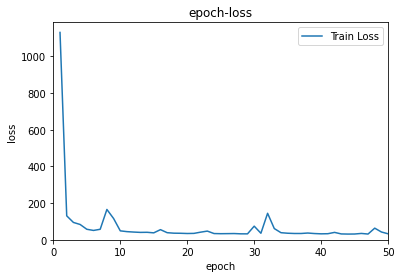

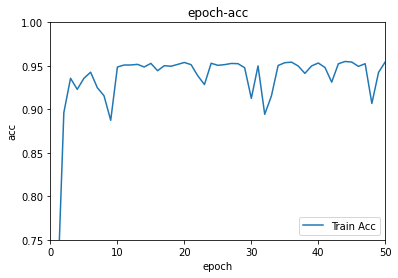

In [8]:
# Visualization
epochs = 50
l = np.array(history.history['loss'])
a = np.array(history.history['accuracy'])
step = np.linspace(1,epochs,epochs)
plt.plot(step,l,label="Train Loss")
plt.legend(loc='upper right')
plt.title('epoch-loss')
plt.xlim((0, epochs))
plt.gca().set_ylim(bottom=0)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('./static/train-loss.png', bbox_inches='tight')
plt.show()
plt.plot(step,a,label="Train Acc")
plt.legend(loc='lower right')
plt.title('epoch-acc')
plt.xlim((0, epochs))
plt.ylim((0.75, 1))
plt.xlabel('epoch')
plt.ylabel('acc')
plt.savefig('./static/train-acc.png', bbox_inches='tight')
plt.show()

In [9]:
model.save("./model/SRCNN.h5")